In [1]:
# Get system path 
import os
path = os.getcwd()
# Get parent directory
parent = os.path.dirname(path)
#Add parent directory to system path
os.sys.path.insert(0, parent)

import numpy as np
import matplotlib.pyplot as plt

from lib.utils import *
from lib.plot_utils import *   
from lib.event_processing import *
from lib.real_time_video import *

from metavision_core.event_io import EventsIterator
from metavision_sdk_core import PeriodicFrameGenerationAlgorithm
from metavision_sdk_ui import EventLoop, BaseWindow, Window, UIAction, UIKeyEvent

# Get the runtimes of the different methods
import time

from numba import jit, njit

#Dynamicaly reload modules in juptyer notebook
%load_ext autoreload 
%autoreload 2

In [12]:
path = "../data/recordings/02_02/recording_2024-02-02_17-21-24_FOV14.3_MAG6.raw"
# path = "../data/recordings/02_02/recording_2024-02-02_17-26-59_FOV11.8_MAG6.raw"

mv_iterator = EventsIterator(input_path=path, delta_t=10000)

height, width = mv_iterator.get_size()  # Camera Geometry
event_frame_gen = PeriodicFrameGenerationAlgorithm(width, height, accumulation_time_us=100000)

frames = np.zeros((height, width,1), dtype=np.uint8)

print(frames.shape)

def on_cd_frame_cb(ts, cd_frame):
    global frames  # Add this line to access the global frames variable
    gray_frame = np.reshape(cv2.cvtColor(cd_frame, cv2.COLOR_BGR2GRAY), (height, width, 1))
    frames = np.append(frames,gray_frame, axis=-1)  # Append the gray_frame as a new row to the frames array
    
event_frame_gen.set_output_callback(on_cd_frame_cb)

for evs in mv_iterator:
    event_frame_gen.process_events(evs)

print(frames.shape)


(720, 1280, 1)
(720, 1280, 115)


In [16]:
innit_fame = np.zeros((height, width,1), dtype=np.uint8)

pixel_to_deg = {'ref_pixel_to_deg': 0.0009500350877192982,
        'reference_FOV': 1,
        'recording_FOV': 13.7}

cluster_frame = ClusterFrame(
    innit_fame,
    pixel_to_deg =pixel_to_deg,
    pixel_range=15, 
    treshold_filter= 0.2, 
    mass_treshold= 0.2, 
    max_number_of_clusters=30)

cluster_frame.load_som_parameters('n80_tycho6')
cluster_frame.load_star_catalog('../data/catalogs/tycho2_VT_6.csv')
cluster_video = ClusterVideo()

<class 'minisom.MiniSom'>
(4566, 3)  Stars loaded


In [23]:

copy = np.copy(frames.shape[2])

# clear copy maintaining shape


In [50]:
path = "../data/recordings/02_02/recording_2024-02-02_17-21-24_FOV14.3_MAG6.raw"
# path = "../data/recordings/02_02/recording_2024-02-02_17-26-59_FOV11.8_MAG6.raw"

mv_iterator = EventsIterator(input_path=path, delta_t=10000)

height, width = mv_iterator.get_size()  # Camera Geometry
event_frame_gen = PeriodicFrameGenerationAlgorithm(width, height, accumulation_time_us=100000)

frames = np.empty((0, height, width), dtype=np.uint8) 

def on_cd_frame_cb(ts, cd_frame):
    global frames  # Add this line to access the global frames variable
    gray_frame = np.reshape(cv2.cvtColor(cd_frame, cv2.COLOR_BGR2GRAY), (1, height, width))
    frames = np.append(frames,gray_frame, axis=0)  # Append the gray_frame as a new row to the frames array
    
event_frame_gen.set_output_callback(on_cd_frame_cb)

frames_buffer = [] # Only list allowed

for evs in mv_iterator:

    event_frame_gen.process_events(evs)

    if frames.shape[0] == 10:
        print (frames.shape)

        frames_buffer.append(frames)
        frames = np.empty((0, height, width), dtype=np.uint8) 
        
print (len(frames_buffer), frames_buffer[0].shape)
# cluster_frame.print_total_time()

(10, 720, 1280)
(10, 720, 1280)
(10, 720, 1280)
(10, 720, 1280)
(10, 720, 1280)
(10, 720, 1280)
(10, 720, 1280)
(10, 720, 1280)
(10, 720, 1280)
(10, 720, 1280)
(10, 720, 1280)
11 (10, 720, 1280)


In [114]:
def blend_buffer(frames_buffer, mirror = False):
    ''' Get a frame buffer and compacts it into a single frame  
    '''

    # Stack all grayscale frames along a new axis
    stacked_frames = np.stack(frames_buffer, axis=0)
    # stacked_frames = np.concatenate(frames_buffer, axis=-1)

    # Average the values along the last axis
    blend = np.mean(stacked_frames, axis=0)

    # Mirror the image
    if mirror:
        blend = np.fliplr(blend)

    return blend.astype(np.uint8) 


def blend_buffer_2(frames_buffer, mirror = False):
    ''' Get a frame buffer and compacts it into a single frame '''
    stacked_frames = np.zeros((height, width), dtype=np.uint8) 
    # Stack all grayscale frames along a new axis
    for i in range(frames_buffer.shape[0]):
        stacked_frames += frames_buffer[i] 
        print(np.max(stacked_frames), np.max(frames_buffer[i]))
    # stacked_frames = np.stack(frames_buffer, axis=0)
    # stacked_frames = np.concatenate(frames_buffer, axis=-1)
    blend = stacked_frames / frames_buffer.shape[0] # Average the frames

    if mirror:
        blend = np.fliplr(blend)
    
    return blend.astype(np.uint8)  # Convert back to uint8 before returning

# start_time = time.time()
# for buffer in frames_buffer:
#     compact_frames = blend_buffer( buffer, True)
# print("--- %s seconds ---" % (time.time() - start_time))

blend_buffer_2( frames_buffer[0], True)
start_time = time.time()
for buffer in frames_buffer:
    compact_frames = blend_buffer_2( buffer, True)
print("--- %s seconds ---" % (time.time() - start_time))

print(compact_frames.shape)
plot_image(np.squeeze(compact_frames))

UFuncTypeError: Cannot cast ufunc 'add' output from dtype('float64') to dtype('uint8') with casting rule 'same_kind'

In [22]:
@njit(fastmath=True)
def blend_buffer(frames_buffer, mirror=False):
    ''' Get a frame buffer and compacts it into a single frame  
    '''
    # Average the values along the last axis
    blend = np.mean(frames_buffer, axis=-1)

    # Mirror the image
    if mirror:
        blend = np.fliplr(blend)

    return blend.astype(np.uint8)  # Convert back to uint8 before returning

max_buffer = 10
# blend = np.array(np.zeros((cv2.cvtColor(np.array(frames[0]), cv2.COLOR_BGR2GRAY).shape)))
copact_frames = []
frames_buffer = []

time_start = time.perf_counter()
for frame in frames:
    frames_buffer.append(frame)
    if len(frames_buffer) == max_buffer:
        stacked_frames = np.stack(frames_buffer, axis=-1)
        blend = blend_buffer(stacked_frames, mirror=True)
        copact_frames.append(blend.astype(np.uint8))
        frames_buffer = []

blend_buffer(frames_buffer, mirror=True)
print('time', time.perf_counter() - time_start)

print(len(copact_frames))

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
[1m[1m[1mNo implementation of function Function(<function mean at 0x7fbc647764d0>) found for signature:
 
 >>> mean(array(uint8, 3d, C), axis=Literal[int](-1))
 
There are 2 candidate implementations:
[1m    - Of which 2 did not match due to:
    Overload in function 'array_mean': File: numba/np/arraymath.py: Line 425.
      With argument(s): '(array(uint8, 3d, C), axis=int64)':[0m
[1m     Rejected as the implementation raised a specific error:
       TypingError: [1mgot an unexpected keyword argument 'axis'[0m[0m
  raised from /home/ignaciozm/.local/lib/python3.10/site-packages/numba/core/typing/templates.py:784
[0m
[0m[1mDuring: resolving callee type: Function(<function mean at 0x7fbc647764d0>)[0m
[0m[1mDuring: typing of call at /tmp/ipykernel_10496/2584990866.py (6)
[0m
[1m
File "../../../../../../tmp/ipykernel_10496/2584990866.py", line 6:[0m
[1m<source missing, REPL/exec in use?>[0m


In [22]:
import numpy as np
from numba import njit

@njit(fastmath=True)
def blend_buffer(frames_buffer, mirror=False):
    ''' Get a frame buffer and compacts it into a single frame  
    '''

    # Compute the dimensions of the input frames
    num_frames, height, width = frames_buffer.shape

    # Initialize an empty array to store the blended frame
    blend = np.zeros((height, width), dtype=np.float64)

    # Loop over each pixel and frame to compute the mean
    for h in range(height):
        for w in range(width):
            pixel_sum = 0.0
            for frame in range(num_frames):
                pixel_sum += frames_buffer[frame, h, w]
            blend[h, w] = pixel_sum / num_frames

    # Mirror the image if required
    if mirror:
        blend = np.fliplr(blend)

    # Convert the result to uint8 before returning
    return blend.astype(np.uint8)

# Example usage:
frames_buffer = np.random.randint(0, 255, size=(100, 480, 640), dtype=np.uint8)
blended_frame = blend_buffer(frames_buffer, mirror=True)


normal 6.7764985000003435
114

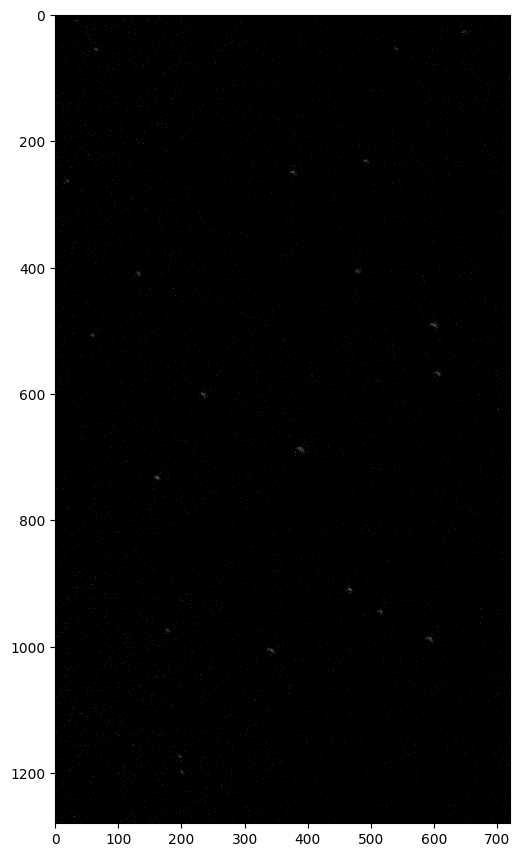

In [5]:
plot_image(frames[1])

In [ ]:
# RUNTIME COMPARATION  

import cv2

def treshold_filter_2(img, treshold):
    '''
    Deletes the pixels with a value below the treshold.

    Parameters
    ----------
    img : numpy array
        Image to be filtered.
    treshold : int
        Treshold value.

    Returns
    -------
    filtered_img : numpy array
        Filtered image.
    '''
    
    # Create a copy of the input image
    filtered_img = np.copy(img)

    # Filter the image with a threshold
    filtered_img[filtered_img < treshold] = 0

    return filtered_img

max_pixel_value = np.max(frames[11])
treshold = round(max_pixel_value*0.7) # 50% of the max pixel value, MODIFY
print(treshold)



# Treshold filter
start = time.time()
filtered_frames_1 = []
for frame in frames:
    filtered_frames_1.append(treshold_filter_2(frame, treshold))
end = time.time()
treshold2_time = end - start

# Treshold filter
start = time.time()
filtered_frames_2 = []
for frame in frames:
    filtered_frames_2.append(treshold_filter(frame, treshold))
end = time.time()
treshold_time = end - start

frames = frames/np.max(frames) # Normalize the frames

start = time.time()
filtered_frames_3 = []
for frame in frames:
    filtered_frames_3.append(cv2.threshold(frame, treshold, 1, cv2.THRESH_TOZERO)[1])
end = time.time()
treshold_time_cv = end - start

# Open cv

print(f'Treshold filter time: {treshold_time}', f'Treshold filter time 2: {treshold2_time}',
      f'Treshold filter time cv: {treshold_time_cv}')
# plot_image(filtered_frames_1[11])
plot_image(filtered_frames_3[11])
print(np.max(filtered_frames_1[11]-filtered_frames_3[11]))

## Max value cluster 

In [45]:
max_index = np.array([5,5])
filtered_img = np.zeros([10,10])
pixel_range = 3



mask = np.zeros_like(filtered_img, dtype=bool)

mask[max_index[0] - pixel_range:max_index[0] + pixel_range + 1,
             max_index[1] - pixel_range:max_index[1] + pixel_range + 1] = True

print(mask)

[[False False False False False False False False False False]
 [False False False False False False False False False False]
 [False False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True  True False]
 [False False  True  True  True  True  True  True  True False]
 [False False False False False False False False False False]]


runtime:  1.0343871116638184
[[array([437, 188]), 320, array([434, 187])], [array([624, 701]), 224, array([625, 701])], [array([718, 272]), 396, array([718, 271])], [array([261, 225]), 414, array([260, 224])], [array([943, 242]), 328, array([944, 241])], [array([547, 106]), 2028, array([543, 108])], [array([547,  58]), 2407, array([540,  62])], [array([813, 271]), 355, array([814, 273])], [array([893, 493]), 1205, array([894, 495])], [array([530, 513]), 2330, array([534, 518])], [array([175,  72]), 227, array([173,  73])], [array([633, 599]), 2136, array([628, 596])], [array([815, 391]), 1442, array([812, 389])], [array([420, 439]), 2040, array([421, 435])], [array([948, 295]), 208, array([948, 295])], [array([1261,  352]), 383, array([1266,  354])], [array([146, 120]), 326, array([144, 121])], [array([688, 522]), 1496, array([684, 520])], [array([1094,  212]), 267, array([1094,  214])], [array([1266,  112]), 181, array([1272,  111])]]


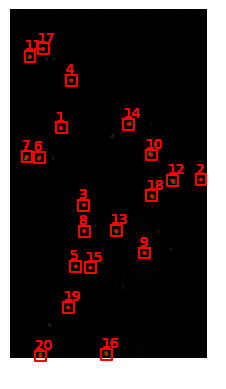

runtime:  1.6257660388946533
[[array([435, 188]), 295, array([434, 187])], [array([623, 701]), 222, array([625, 701])], [array([717, 271]), 366, array([718, 271])], [array([261, 225]), 403, array([260, 224])], [array([943, 242]), 314, array([944, 241])], [array([547, 106]), 2026, array([543, 108])], [array([547,  58]), 2376, array([540,  62])], [array([812, 271]), 328, array([814, 273])], [array([893, 493]), 1147, array([894, 495])], [array([529, 513]), 2314, array([534, 518])], [array([174,  71]), 211, array([173,  73])], [array([633, 599]), 2132, array([628, 596])], [array([815, 391]), 1425, array([812, 389])], [array([420, 439]), 2015, array([421, 435])], [array([948, 294]), 197, array([948, 295])], [array([1261,  352]), 377, array([1266,  354])], [array([145, 120]), 307, array([144, 121])], [array([688, 522]), 1486, array([684, 520])], [array([1094,  212]), 251, array([1094,  214])], [array([1266,  111]), 175, array([1272,  111])]]


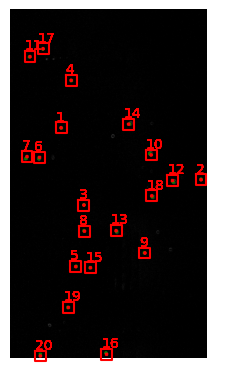

In [53]:
def max_value_cluster(img, pixel_range, n_clusters, iterations=1):

    '''
    Creates a list of clusters searching the the maximun pixel value and performing the center of mass 
    of the pixels around it. The pixels that are part of the cluster are deleted and the process is repeated.

    Parameters
    ----------
    img : numpy array
        Image to be filtered.
    pixel_range : int
        Range of pixels to be considered around the maximun pixel value to perform the center of mass 
        (clustering).
    n_clusters : int
        Number of clusters to be found.
    iterations : int, optional
        Number of times the clustering is performed. When iterating the clusters are ordered by the cluster 
        mass and the index used a preliminary stimations . The default is 1.

    Returns
    -------
    clusters : list
        List of clusters. Each cluster is a list with the following structure:
            [ [x_pixel, y_pixel], cluster comulative mass, inital cluster position [x_max, y_max] ]    
    
    '''
    # Create a copy of the input image
    filtered_img = np.copy(img)

    clusters = []

    for i in range(n_clusters):
        # Get the maximun pixel value
        max_index = np.unravel_index(np.argmax(filtered_img), filtered_img.shape)

        cluster_x = 0
        cluster_y = 0
        cluster_mass = 0
        # Performs the clustering on the pixel range around the maximun pixel value
        for i in range(-pixel_range, pixel_range):
            for j in range(-pixel_range, pixel_range):
                if max_index[0]+i < filtered_img.shape[0] and max_index[1]+j < filtered_img.shape[1]:
                    
                    cluster_x += filtered_img[max_index[0] + i , max_index[1] + j ] * i
                    cluster_y += filtered_img[max_index[0] + i , max_index[1] + j ] * j
                    cluster_mass += filtered_img[max_index[0] + i , max_index[1] + j ] 

                    # Delete the pixels that are part of the cluster to find another maximun
                    filtered_img[max_index[0] + i , max_index[1] + j ] = 0

        if cluster_mass != 0:
            clusters.append([ np.round(max_index + [cluster_x, cluster_y]/cluster_mass).astype(int), 
                            cluster_mass, 
                            np.array(max_index)]) 

    return clusters

def max_value_cluster_2(img, pixel_range, n_clusters):
    # Create a copy of the input image
    filtered_img = np.copy(img)

    clusters = []

    for i in range(n_clusters):
        # Get the maximun pixel value
        max_index = np.unravel_index(np.argmax(filtered_img), filtered_img.shape)

        cluster_x = 0
        cluster_y = 0
        cluster_mass = 0

        # Create a mask to select the pixels within the pixel range
        mask = np.zeros_like(filtered_img, dtype=bool)
        mask[max_index[0] - pixel_range:max_index[0] + pixel_range + 1,
             max_index[1] - pixel_range:max_index[1] + pixel_range + 1] = True


        # Get the coordinates and values of the pixels within the mask
        coords = np.argwhere(mask)
        values = filtered_img[mask]

        # Perform the clustering using vectorized operations
        cluster_x = np.sum(coords[:, 0] * values)
        cluster_y = np.sum(coords[:, 1] * values)
        cluster_mass = np.sum(values)

        # Calculate the cluster centroid
        centroid = None 
        if cluster_mass != 0:
            centroid = np.round([cluster_x, cluster_y] / cluster_mass).astype(int)
        cluster_position = np.array(max_index)

        # Append the cluster to the list
        clusters.append([centroid , cluster_mass, cluster_position])

        # Set the pixels within the mask to zero
        filtered_img[mask] = 0

    return clusters

start = time.time()
filtered_frames_1 = []
for frame in frames:
    filtered_frames_1.append(max_value_cluster_2(frame, pixel_range = 20, n_clusters = 20))
end = time.time()
print('runtime: ', end - start )
print(filtered_frames_1[2])
plot_cluster(frames[2], filtered_frames_1[2], 20)

start = time.time()
filtered_frames_1 = []
for frame in frames:
    filtered_frames_1.append(max_value_cluster(frame, pixel_range = 20, n_clusters = 20, iterations=1))
end = time.time()
print('runtime: ', end - start )
print(filtered_frames_1[2])
plot_cluster(frames[2], filtered_frames_1[2], 20)



In [9]:
import numpy as np

def max_value_cluster2(img, pixel_range, n_clusters):
    '''
    Creates a list of clusters searching for the maximum pixel value and performing the center of mass 
    of the pixels around it. The pixels that are part of the cluster are deleted, and the process is repeated.

    Parameters
    ----------
    img : numpy array
        Image to be filtered.
    pixel_range : int
        Range of pixels to be considered around the maximum pixel value to perform the center of mass 
        (clustering).
    n_clusters : int
        Max number of clusters to be found.

    Returns
    -------
    clusters : list
        List of clusters. Each cluster is a list with the following structure:
            [ [x_pixel, y_pixel], cluster cumulative mass, initial cluster position [x_max, y_max] ]    
    
    '''
    # Create a copy of the input image
    filtered_img = np.copy(img)

    clusters = []

    for i in range(n_clusters):
        # Get the maximum pixel value and its index
        max_index = np.unravel_index(np.argmax(filtered_img), filtered_img.shape)

        # Define the region of interest around the maximum pixel value
        start_row = max_index[0] - pixel_range
        end_row = max_index[0] + pixel_range + 1
        start_col = max_index[1] - pixel_range
        end_col = max_index[1] + pixel_range + 1

        # Ensure the region of interest does not go out of bounds
        if start_row < 0:
            start_row = 0
        if end_row > filtered_img.shape[0]:
            end_row = filtered_img.shape[0]
        if start_col < 0:
            start_col = 0
        if end_col > filtered_img.shape[1]:
            end_col = filtered_img.shape[1]

        # Create a mask to select the pixels within the pixel range
        mask = np.zeros_like(filtered_img, dtype=bool)
        mask[start_row:end_row, start_col:end_col] = True

        # Get the coordinates and values of the pixels within the mask
        coords = np.argwhere(mask)
        values = filtered_img[mask]

        # Perform the clustering using vectorized operations
        cluster_x = np.sum(coords[:, 0] * values)
        cluster_y = np.sum(coords[:, 1] * values)
        cluster_mass = np.sum(values)

        # Calculate the cluster centroid
        if cluster_mass != 0:
            cluster_position = np.round([cluster_x, cluster_y] / cluster_mass).astype(int)
            # Append the cluster to the list
            clusters.append([cluster_position, cluster_mass, np.array(max_index)])

        # Set the pixels within the mask to zero 
        filtered_img[mask] = 0

    return clusters

start = time.perf_counter()
for i in range(10):
    max_value_cluster2(frames[2], pixel_range = 15, n_clusters = 30)
print('runtime: ', (time.perf_counter() - start)/10 )


start = time.perf_counter()
for i in range(10):
    max_value_cluster(frames[2], pixel_range = 15, n_clusters = 30)
print('runtime: ', (time.perf_counter() - start)/10 )

runtime:  0.26751137120008933
runtime:  0.15805717959992763
